In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
# import cv2

In [22]:
from QAOAKit.compressed_sensing import (
    recon_by_Lasso
) 

In [31]:
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

# read original image and downsize for speed
Xorig = plt.imread('escher_waterfall.jpeg')
# print(Xorig.shape)
t = np.linspace(0, 1, 36)
x = np.cos(2 * 97 * np.pi * t) + np.cos(2 * 777 * np.pi * t) + 2
x = x.reshape(-1, 1)
x = np.repeat(x, 4*36, axis=1)
# print(x.shape)
X = x
# Xorig
# Xorig = spimg.imread('escher_waterfall.jpeg', flatten=True, mode='L') # read in grayscale
# X = spimg.zoom(Xorig, 0.04)
ny,nx = X.shape

In [35]:
# extract small sample of signal
k = round(nx * ny * 0.5) # 50% sample
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = X.T.flat[ri]
# b = np.expand_dims(b, axis=1)

# create dct matrix operator using kron (memory errors for large ny*nx)
A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )
A = A[ri,:] # same as phi times kron

# vx = recon_by_Lasso(A, b, 0.1)
# Xat2 = vx

# do L1 optimization
vx = cvx.Variable(nx * ny)
objective = cvx.Minimize(cvx.norm(vx, 1))
# b = b.reshape(-1)
constraints = [A*vx == b]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)
Xat2 = np.array(vx.value).squeeze()

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Aug 10 03:16:18 PM: Your problem has 5184 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 10 03:16:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 10 03:16:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 10 03:16:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 10 03:16:18 PM: Compiling problem (target solver=ECOS).
(CVXPY) Aug 10 03:16:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

/Users/kunliu/miniforge3/envs/py39_mitiq/lib/python3.9/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Aug 10 03:16:21 PM: Applying reduction ECOS
(CVXPY) Aug 10 03:16:23 PM: Finished problem compilation (took 5.057e+00 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Aug 10 03:16:23 PM: Invoking solver ECOS  to obtain a solution.

ECOS 2.0.10 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +4e+05  1e+00  1e-02  1e+00  4e+01    ---    ---    2  1  - |  -  - 
 1  +1.945e+02  +1.975e+02  +2e+05  9e-01  5e-03  3e+00  2e+01  0.6555  1e-01   1  1  1 |  0  0
 2  +2.636e+02  +2.648e+02  +5e+04  8e-01  1e-03  1e+00  5e+00  0.7412  3e-02   1  0  1 |  0  0
 3  +3.065e+02  +3.069e+02  +1e+04  4e-01  4e-04  4e-01  1e+00  0.7274  2e-02 

In [40]:
# reconstruct signal
Xat = Xat2.reshape(nx, ny).T # stack columns
Xa = idct2(Xat)

# confirm solution
if not np.allclose(X.T.flat[ri], Xa.T.flat[ri]):
    print('Warning: values at sample indices don\'t match original.')

# create images of mask (for visualization)
X_max = np.max(X)
mask = np.zeros(X.shape)
mask.T.flat[ri] = X_max
Xm = X_max * np.ones(X.shape)
Xm.T.flat[ri] = X.T.flat[ri]

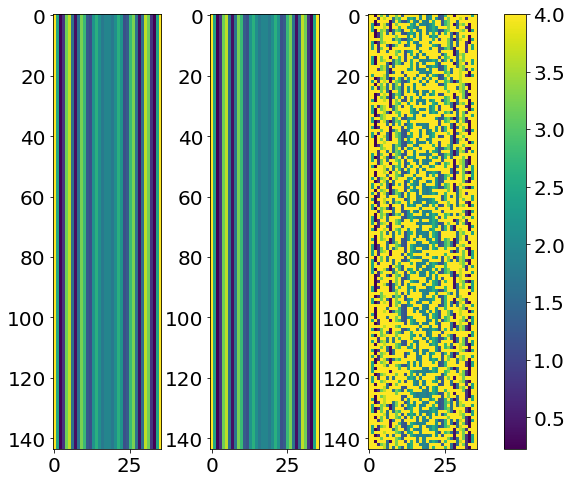

In [48]:
# plt.rc('font', size=20)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 8))
# fig, axs = plt.subplots(1, 4)
axs = axs.reshape(-1)
axs[0].imshow(X.T)
# axs[1].imshow(mask.T)
axs[1].imshow(Xa.T)
im = axs[2].imshow(Xm.T)

fig.colorbar(im, ax=[axs[i] for i in range(3)])
plt.show()